In [1]:
# importing all the required libraries
import pandas as pd
import numpy as np
import librosa
from glob import glob
from tqdm.notebook import tqdm

import os
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# readind data csv file
df = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# total classes
df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [4]:
# use to encode classes into numbers
lb = LabelEncoder()
lb.fit(df['class'])
df['class'] = lb.transform(df['class'])

In [5]:
# class output after converting
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,3
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,2
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,2
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,2
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,2


In [6]:
# different classes data in different folds
appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())
 
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,0,1,2,3,4,5,6,7,8,9
0,fold1,100,36,100,100,100,96,35,120,86,100
1,fold2,100,42,100,100,100,100,35,120,91,100
2,fold3,100,43,100,100,100,107,36,120,119,100
3,fold4,100,59,100,100,100,107,38,120,166,100
4,fold5,100,98,100,100,100,107,40,120,71,100
5,fold6,100,28,100,100,100,107,46,68,74,100
6,fold7,100,28,100,100,100,106,51,76,77,100
7,fold8,100,30,100,100,100,88,30,78,80,100
8,fold9,100,32,100,100,100,89,31,82,82,100
9,fold10,100,33,100,100,100,93,32,96,83,100


In [16]:
# plotting wave of an audio file and importing audio to listen

def path_class(filename):
    excerpt = df[df['slice_file_name'] == filename]
    path_name = os.path.join('/kaggle/input/urbansound8k/', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
#     wav_sample,rate = librosa.load(full_path,sr=None,mono=False)
    print(wav_sample.shape)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

(176400, 2)
sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  2


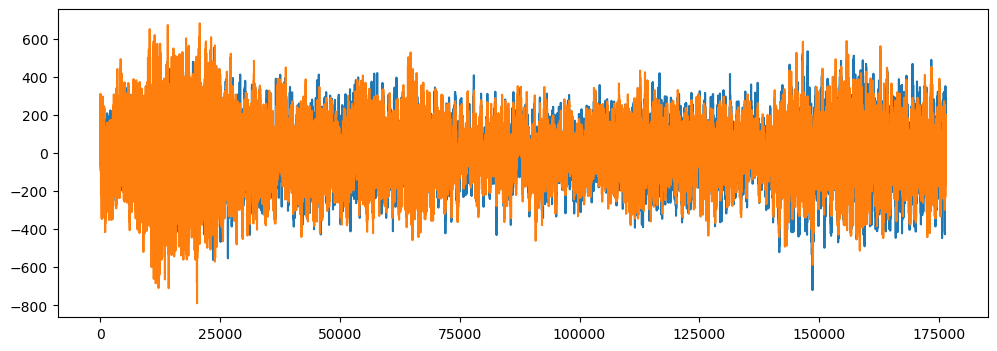

In [8]:
fullpath, label = path_class('100263-2-0-137.wav')
wav_plotter(fullpath,label)

#### Urban Sound 8k suggests to train the data in folds as given and use 10 fold cross validation.
#### That means we create 10 models and use diff 9 folds to train at a time and left one to 
#### test accuracy of model and average out the accuracy.

## using mfcc features and ANN to classify sound

In [15]:
#converting data into mfcc features and storing it fold wise
data = []
for i in tqdm(range(1,11)):
    fea,lab = [],[]
    fold = 'fold'+str(i)
    for file in os.listdir(os.path.join('/kaggle/input/urbansound8k/',fold)):
        path = os.path.join('/kaggle/input/urbansound8k/',fold,file)
        
        # loading audio from path
        y,sr = librosa.load(path)
        
        # extracting features loaded audio numpy data
        mfc_feature = np.mean(librosa.feature.mfcc(y=y,n_mfcc=40).T,axis=0)
        
        # appending features and labels
        fea.append(mfc_feature)
        lab.append(df[df.slice_file_name == file].reset_index().loc[0,'class'])
    # converting to numpy array
    fea = np.array(fea)
    lab = np.array(lab)
    data.append([fea,lab])         

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"


In [34]:
# creating a model function to train on differnt folds
def clf(x,y,x_test,y_test):
    model = tf.keras.models.Sequential([
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dense(1024,activation='relu'),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(10,activation='softmax'),
                                       ])
    # creating an early stopping
    es = EarlyStopping(monitor='acc',min_delta=0.01,patience=3)
    # compiling model
    model.compile(optimizer = Adam(lr=0.01),loss = 'categorical_crossentropy',metrics=['acc'])
    # fitting the model
    model.fit(x,y,epochs=10,validation_data=(x_test,y_test),callbacks = es)
    return model

In [20]:
# conerting data to np array
data = np.array(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [35]:
X_data = data[:,0]
Y_data = data[:,1]
# variable to store model
met = []

for i in range(10):
    # picking one fold as test data
    X_test = np.array(X_data[i])
    Y_test = tf.keras.utils.to_categorical(Y_data[i])
    
    # rest folds data are combined and stored for training data 
    X_train,Y_train = [],[]
    for j in range(10):
        if j == i:
            continue
        if len(X_train) == 0:
            X_train = X_data[j]
            Y_train = Y_data[j]
        else:
            
            X_train = np.concatenate([X_train,X_data[j]])
            Y_train = np.concatenate([Y_train,Y_data[j]])
    Y_train = tf.keras.utils.to_categorical(Y_train)
    
    # Printing shapes of data train and test and training model
    print('Fold '+str(i+1))
    print('Train Shape -> ',X_train.shape,Y_train.shape)
    print('Test Shape -> ',X_test.shape,Y_test.shape)
    m = clf(X_train,Y_train,X_test,Y_test)
    met.append(m)

Fold 1
Train Shape ->  (7859, 40) (7859, 10)
Test Shape ->  (873, 40) (873, 10)
Epoch 1/10
246/246 [==============================] - 4s 6ms/step - loss: 1.7977 - acc: 0.5150 - val_loss: 2.3633 - val_acc: 0.3918
Epoch 2/10
246/246 [==============================] - 1s 5ms/step - loss: 0.9047 - acc: 0.6973 - val_loss: 2.6261 - val_acc: 0.4490
Epoch 3/10
246/246 [==============================] - 1s 5ms/step - loss: 0.6870 - acc: 0.7741 - val_loss: 3.3234 - val_acc: 0.4444
Epoch 4/10
246/246 [==============================] - 1s 5ms/step - loss: 0.5488 - acc: 0.8137 - val_loss: 3.0524 - val_acc: 0.4021
Epoch 5/10
246/246 [==============================] - 2s 7ms/step - loss: 0.4251 - acc: 0.8532 - val_loss: 3.7131 - val_acc: 0.4536
Epoch 6/10
246/246 [==============================] - 1s 5ms/step - loss: 0.3790 - acc: 0.8721 - val_loss: 3.4943 - val_acc: 0.4880
Epoch 7/10
246/246 [==============================] - 1s 5ms/step - loss: 0.3085 - acc: 0.9010 - val_loss: 4.1173 - val_acc: 0.4

Model fold 1 as val data


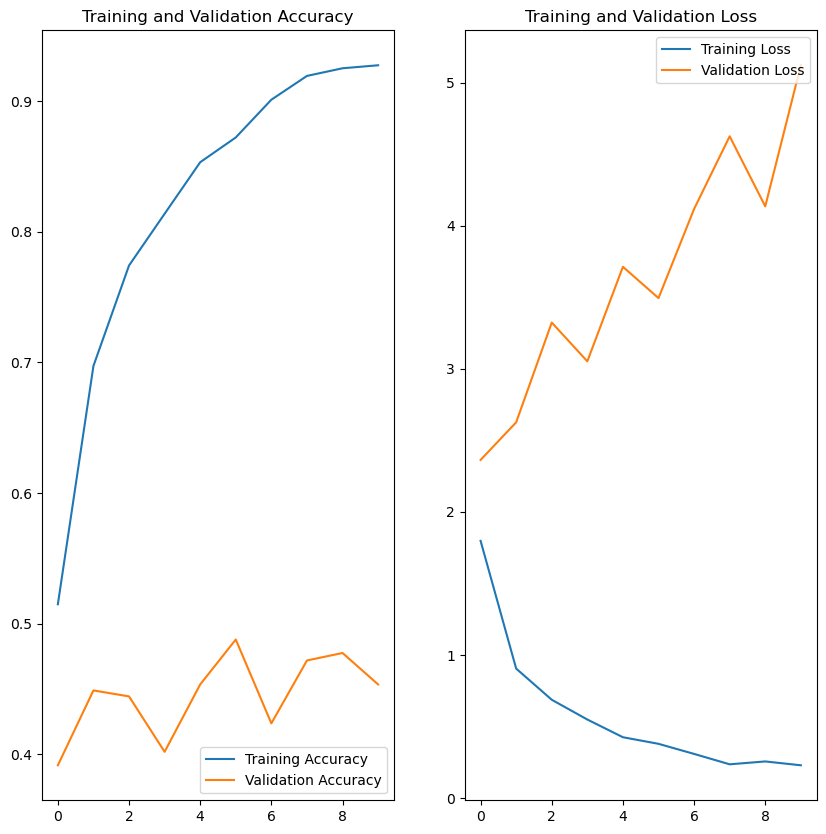

Model fold 2 as val data


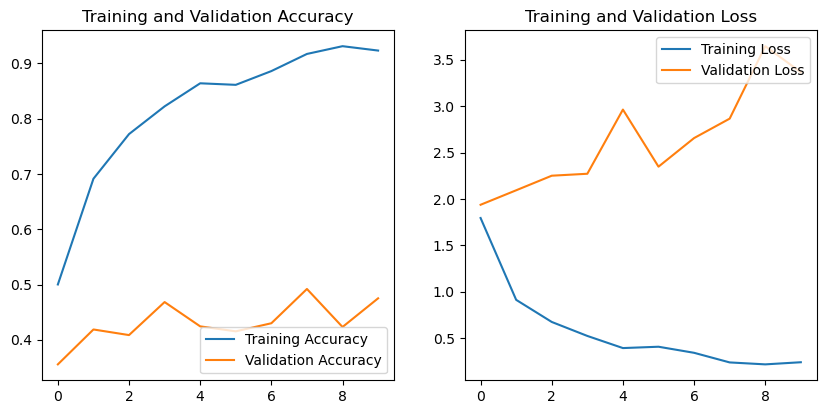

Model fold 3 as val data


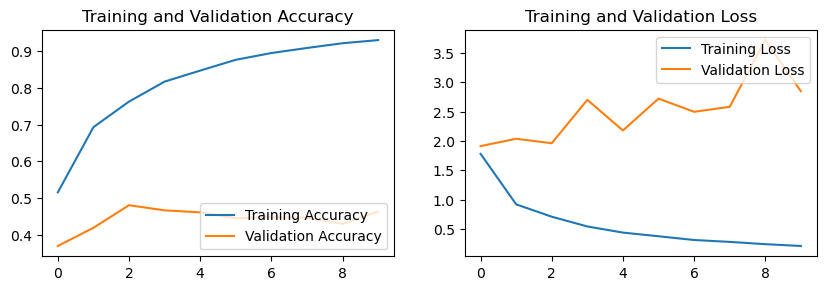

Model fold 4 as val data


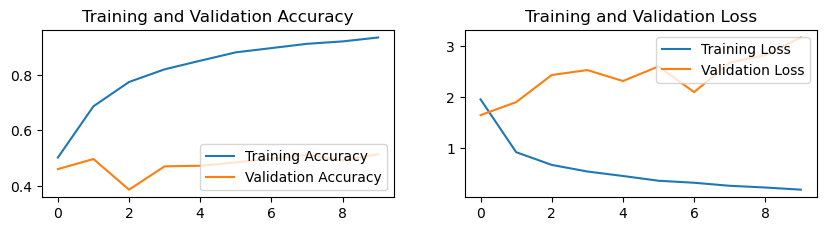

Model fold 5 as val data


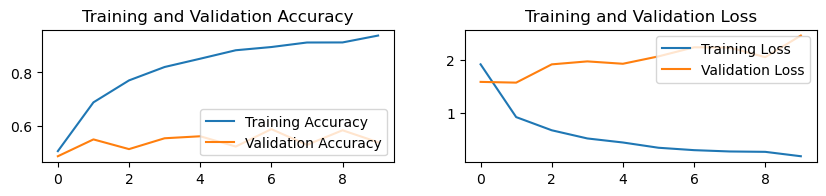

Model fold 6 as val data


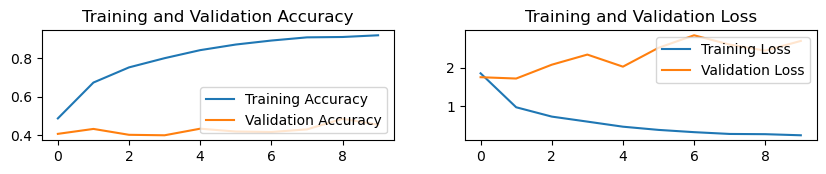

Model fold 7 as val data


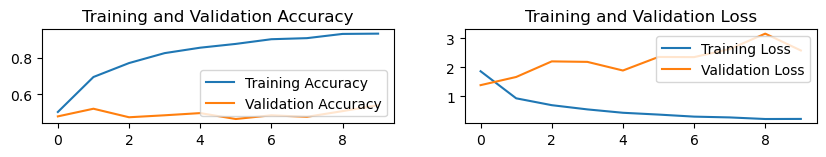

Model fold 8 as val data


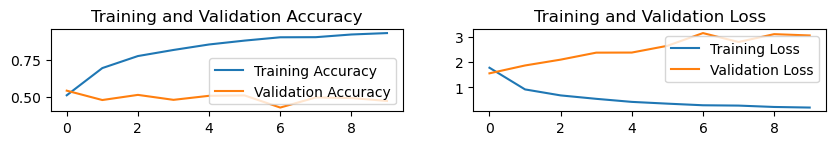

Model fold 9 as val data


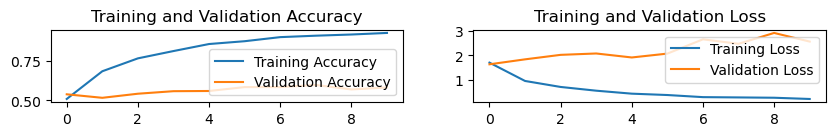

Model fold 10 as val data


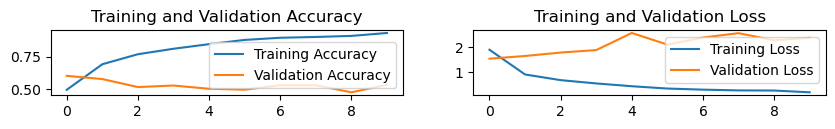

In [45]:
 # plotting train and val accuracy
for i in range(len(met)):
    print('Model fold',i+1,'as val data')    
    # visualizing accuracy and losses
    acc = met[i].history.history['acc']
    val_acc = met[i].history.history['val_acc']

    loss = met[i].history.history['loss']
    val_loss = met[i].history.history['val_loss']

    epochs_range = met[i].history.epoch

    plt.figure(figsize=(10,10))
    plt.subplot(i+1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(i+1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Conclusion : In mfcc training data accuracy increases but not so with validation data

## using mel spectrogram features and CNN to classify sound
### It is the most efficient way to use mel spectrogram as image to classify as sound

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

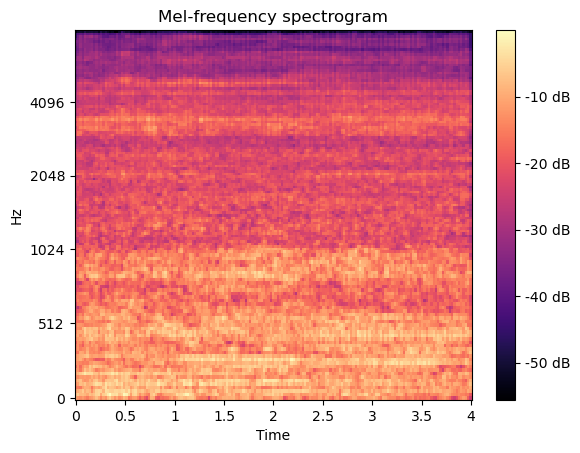

In [6]:
# plotting mel spectrogram of few samples
wav_sample , rate = librosa.load('/kaggle/input/urbansound8k/fold1/103074-7-1-3.wav')
S = librosa.feature.melspectrogram(y=wav_sample)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [8]:
# getting max audio to augment audio to same length to ensure same shape of mel spectrogram
max_len_aud = max(df['end']-df['start'])

In [10]:
data_mel = []
for i in tqdm(range(1,11)):
    fea,lab = [],[]
    fold = 'fold'+str(i)

    for file in os.listdir(os.path.join('/kaggle/input/urbansound8k',fold)):
        path = os.path.join('/kaggle/input/urbansound8k',fold,file)
        
        #loading audio
        y,sr = librosa.load(path)
        
        # fixing the length of audio to max size
        y = librosa.util.fix_length(y,size=int(max_len_aud*sr))
        
        #loading mel spectrogram features
        mfc_feature = librosa.feature.melspectrogram(y=y)
        
        # appending features and labels to this fold data
        fea.append(mfc_feature.reshape(mfc_feature.shape[0],mfc_feature.shape[1],1))
        lab.append(df[df.slice_file_name == file].reset_index().loc[0,'class'])
    # converting to np array and appending to main data
    fea = np.array(fea)
    lab = np.array(lab)
    data_mel.append([fea,lab]) 


  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
# converting to np array
data_mel = np.array(data_mel)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [12]:
# defining model function 
def clf_mel(x,y,x_test,y_test):
    mod1 = tf.keras.models.Sequential([
        Conv2D(32,(3,3),activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64,(3,3),activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(32,(3,3),activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dense(1024,activation='relu'),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(10,activation='softmax')
        ])
    
    # defining early stopping
    es = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3)
    
    # compiling and fitting model
    mod1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    mod1.fit(x,y,epochs=10,validation_data=(x_test,y_test),callbacks = es)
    return mod1

In [13]:
# training models into 10 folds Cross Validation
X_data_mel = data_mel[:,0]
Y_data_mel = data_mel[:,1]
# for saving models
met_mel = []

for i in range(10):
    # test data i for validation
    X_test_mel = np.array(X_data_mel[i])
    Y_test_mel = tf.keras.utils.to_categorical(Y_data_mel[i])
    
    # appending left folds data for training
    X_train_mel,Y_train_mel = [],[]
    for j in range(10):
        if j == i:
            continue
        if len(X_train_mel) == 0:
            X_train_mel = X_data_mel[j]
            Y_train_mel = Y_data_mel[j]
        else:
            
            X_train_mel = np.concatenate([X_train_mel,X_data_mel[j]])
            Y_train_mel = np.concatenate([Y_train_mel,Y_data_mel[j]])
    Y_train_mel = tf.keras.utils.to_categorical(Y_train_mel)
    
    # Printing shapes of data train and test and training model
    print('Fold '+str(i+1))
    print('Train Shape -> ',X_train_mel.shape,Y_train_mel.shape)
    print('Test Shape -> ',X_test_mel.shape,Y_test_mel.shape)
    
    # training model
    m_mel = clf_mel(X_train_mel,Y_train_mel,X_test_mel,Y_test_mel)
    met_mel.append(m_mel)

Fold 1
Train Shape ->  (7859, 128, 173, 1) (7859, 10)
Test Shape ->  (873, 128, 173, 1) (873, 10)
Epoch 1/10
246/246 [==============================] - 18s 23ms/step - loss: 1.8126 - acc: 0.3729 - val_loss: 1.5020 - val_acc: 0.3837
Epoch 2/10
246/246 [==============================] - 5s 21ms/step - loss: 1.2768 - acc: 0.5555 - val_loss: 1.2848 - val_acc: 0.5475
Epoch 3/10
246/246 [==============================] - 5s 22ms/step - loss: 0.9617 - acc: 0.6718 - val_loss: 1.3675 - val_acc: 0.5246
Epoch 4/10
246/246 [==============================] - 5s 20ms/step - loss: 0.7994 - acc: 0.7446 - val_loss: 1.7598 - val_acc: 0.5613
Epoch 5/10
246/246 [==============================] - 5s 20ms/step - loss: 0.6066 - acc: 0.8006 - val_loss: 1.8448 - val_acc: 0.5991
Fold 2
Train Shape ->  (7844, 128, 173, 1) (7844, 10)
Test Shape ->  (888, 128, 173, 1) (888, 10)
Epoch 1/10
246/246 [==============================] - 9s 24ms/step - loss: 1.8343 - acc: 0.3746 - val_loss: 1.5715 - val_acc: 0.4324
Epoch

Model fold 1 as val data


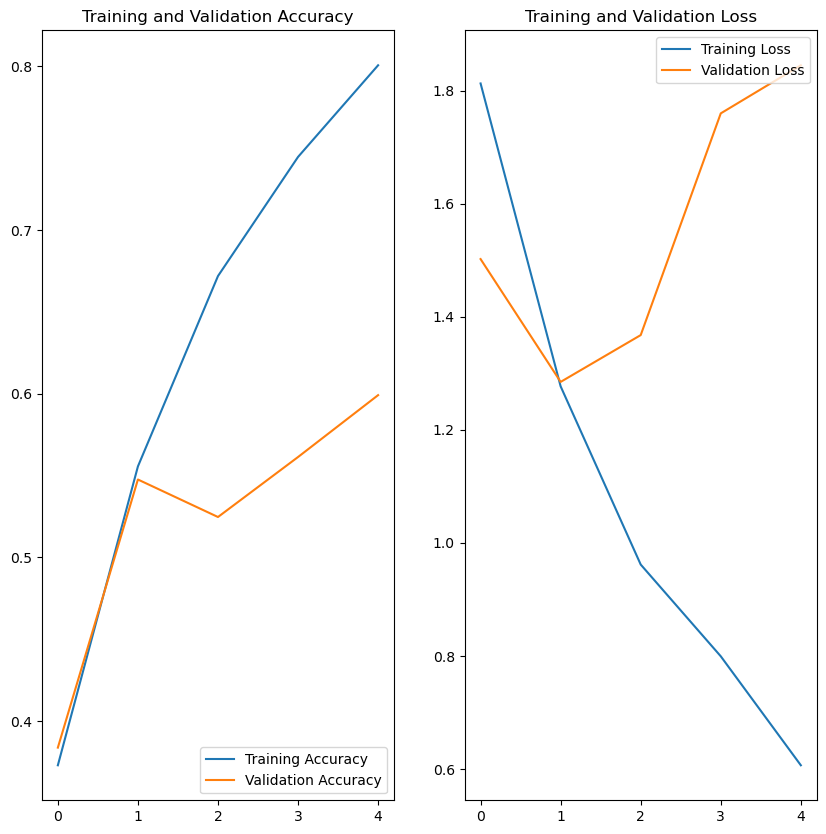

Model fold 2 as val data


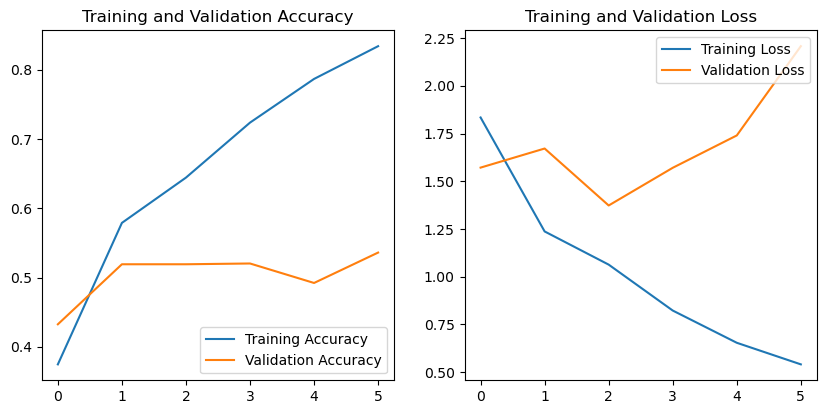

Model fold 3 as val data


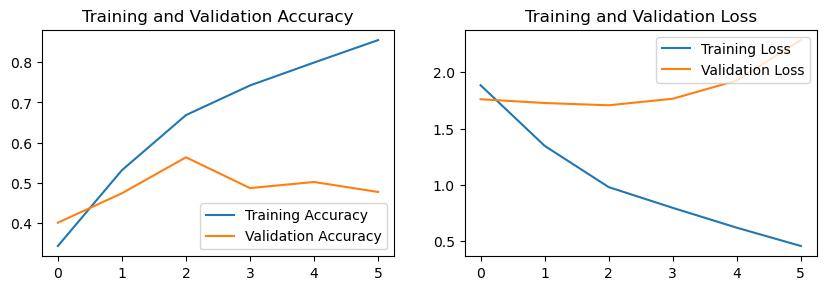

Model fold 4 as val data


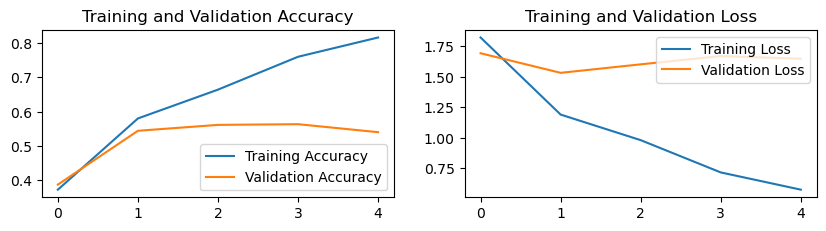

Model fold 5 as val data


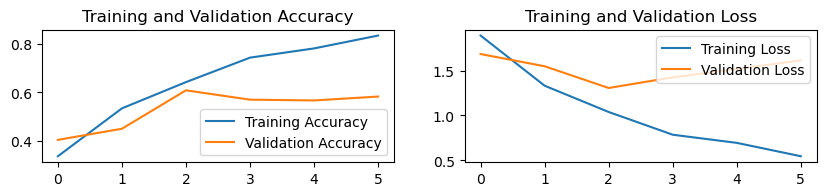

Model fold 6 as val data


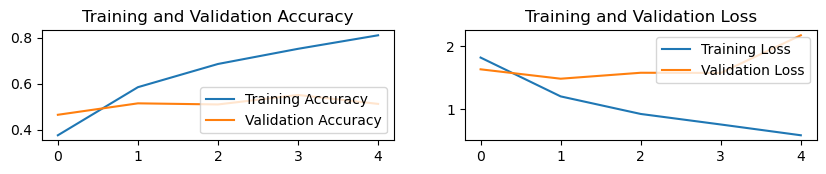

Model fold 7 as val data


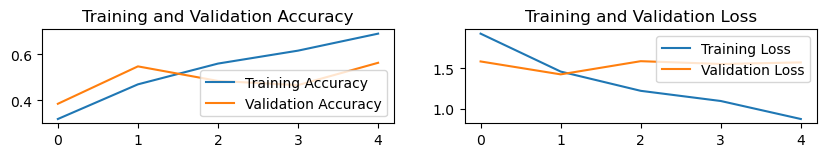

Model fold 8 as val data


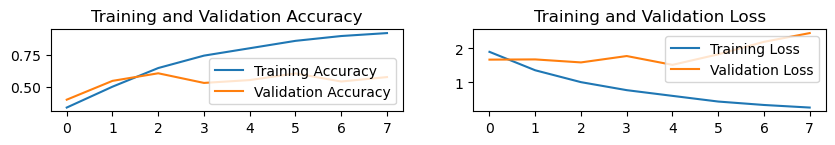

Model fold 9 as val data


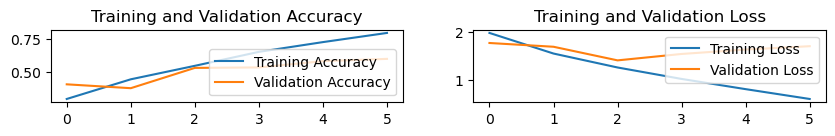

Model fold 10 as val data


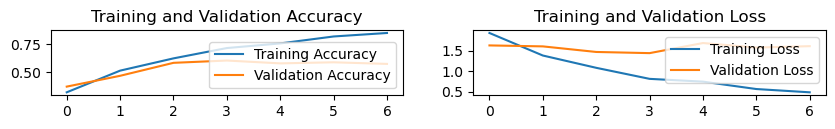

In [15]:
  # plotting train and val accuracy
for i in range(len(met_mel)):
    print('Model fold',i+1,'as val data')    
    # visualizing accuracy and losses
    acc = met_mel[i].history.history['acc']
    val_acc = met_mel[i].history.history['val_acc']

    loss = met_mel[i].history.history['loss']
    val_loss = met_mel[i].history.history['val_loss']

    epochs_range = met_mel[i].history.epoch

    plt.figure(figsize=(10,10))
    plt.subplot(i+1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(i+1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Conclusion :- It can be seen that mel spectrogram features used as image and CNN 
##               to classify performs better than mfcc and ANN.

# Testing

1/1 [==============================] - 0s 43ms/step
True -> ['jackhammer']
Predicted -> ['jackhammer']

(192000, 2)
sampling rate:  48000 Hz
bit depth:  24
number of channels:  2
duration:  4.0  second
number of samples:  192000
class:  7


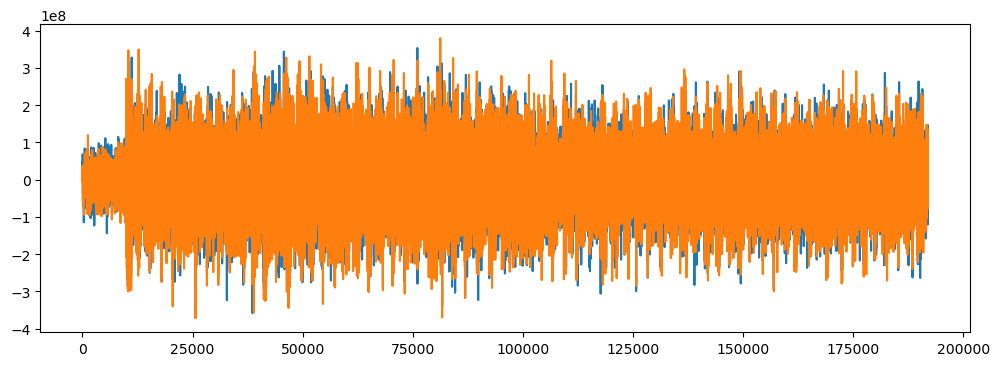

In [40]:
fp,lab = path_class('103074-7-0-0.wav')
wav_aud,sr = librosa.load(fp)
wav_aud = librosa.util.fix_length(wav_aud,size=int(max_len_aud*sr))

S = librosa.feature.melspectrogram(y=wav_aud)
S = S.reshape(1,S.shape[0],S.shape[1],1)

model = met_mel[0]   # as using fold 1 audio
y = model.predict(S)
y = y.argmax()

print('True ->',lb.inverse_transform([lab]))
print('Predicted ->',lb.inverse_transform([y]))
print()
wav_plotter(fp,lab)   # plotting the wave

## We can see that it predicted correct output.

In [10]:
# # getting mfcc features of all audio and it's labels
# X,Y = [],[]
# for path in tqdm(paths):
    
#     y,sr = librosa.load(path)
#     mfc_feature = np.mean(librosa.feature.mfcc(y=y,n_mfcc=40).T,axis=0)
#     mfc_feature = mfc_feature.reshape(1,-1)
#     file = path.split('/')[-1]
#     lab = df[df.slice_file_name == file].reset_index().loc[0,'class']
#     if len(X) == 0:
#         X = mfc_feature
#         Y = lab
#     else:
#         X = np.append(X,mfc_feature,axis=0)
#         Y = np.append(Y,lab)

  0%|          | 0/8732 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"


KeyboardInterrupt: 

In [16]:

# X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=123,test_size=0.2)

In [17]:
# model = tf.keras.models.Sequential([
#         Dense(256,activation='relu'),
#         Dense(512,activation='relu'),
#         Dense(1024,activation='relu'),
#         Dense(512,activation='relu'),
#         Dense(256,activation='relu'),
#         Dense(10,activation='softmax')
#                                        ])
# model.compile(optimizer = Adam(lr=0.01),loss = 'categorical_crossentropy',metrics=['acc'])

In [18]:
# model.fit(X_train,Y_train,epochs=10,validation_data=(X_test,Y_test))

Epoch 1/10
219/219 [==============================] - 8s 6ms/step - loss: 2.0011 - acc: 0.4901 - val_loss: 1.1340 - val_acc: 0.6073
Epoch 2/10
219/219 [==============================] - 1s 5ms/step - loss: 0.9981 - acc: 0.6627 - val_loss: 0.9265 - val_acc: 0.6926
Epoch 3/10
219/219 [==============================] - 1s 5ms/step - loss: 0.7473 - acc: 0.7492 - val_loss: 0.7317 - val_acc: 0.7647
Epoch 4/10
219/219 [==============================] - 1s 5ms/step - loss: 0.6007 - acc: 0.7990 - val_loss: 0.5422 - val_acc: 0.8157
Epoch 5/10
219/219 [==============================] - 1s 5ms/step - loss: 0.4735 - acc: 0.8407 - val_loss: 0.4718 - val_acc: 0.8403
Epoch 6/10
219/219 [==============================] - 1s 5ms/step - loss: 0.3877 - acc: 0.8644 - val_loss: 0.4860 - val_acc: 0.8386
Epoch 7/10
219/219 [==============================] - 1s 5ms/step - loss: 0.3385 - acc: 0.8859 - val_loss: 0.4892 - val_acc: 0.8300
Epoch 8/10
219/219 [==============================] - 1s 5ms/step - loss: 0.

In [22]:
# X_test.shape,Y_test.shape

((1747, 40), (1747, 10))

In [30]:
# Y_predict = model.predict(X_test)

55/55 [==============================] - 0s 2ms/step


In [31]:
# Y_predict = Y_predict.argmax(axis=1)
# Y_test = Y_test.argmax(axis=1)

In [38]:
# accuracy_score(Y_test,Y_predict)

0.8746422438465942

In [33]:
# confusion_matrix(Y_test,Y_predict)

array([[170,   0,   3,   1,   1,   1,   1,   0,   1,   3],
       [  0,  69,   0,   2,   1,   1,   0,   0,   0,   5],
       [  7,   1, 162,  16,   3,   0,   3,   1,   0,  19],
       [  0,   0,   5, 182,   3,   1,   6,   1,   4,   9],
       [  0,   0,   3,   7, 186,   0,   0,   2,   0,   8],
       [  0,   0,   1,   1,   0, 198,   0,   0,   0,   3],
       [  0,   0,   4,   9,   1,   1,  54,   0,   2,   4],
       [  0,   0,   0,   0,   8,   0,   0, 179,   0,   3],
       [  0,   0,   7,  12,   0,   3,   2,   0, 159,   2],
       [  3,   1,  14,   7,   3,   3,   1,   4,   1, 169]])

In [36]:
# print(classification_report(Y_test,Y_predict))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       181
           1       0.97      0.88      0.93        78
           2       0.81      0.76      0.79       212
           3       0.77      0.86      0.81       211
           4       0.90      0.90      0.90       206
           5       0.95      0.98      0.96       203
           6       0.81      0.72      0.76        75
           7       0.96      0.94      0.95       190
           8       0.95      0.86      0.90       185
           9       0.75      0.82      0.78       206

    accuracy                           0.87      1747
   macro avg       0.88      0.87      0.87      1747
weighted avg       0.88      0.87      0.88      1747

